In [136]:
'''
Helper functions to do EDA
'''

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

For categorical variables:

* Count for each category; percentage for each category (+ missing values)
* Bar plot

For categorical variables vs categorical target:

* Count and pct for each category
* Count and pct for each category-target
* Grouped bar plot

For categorical variables vs numerical target:

* Describe of numerical target
* Describe of numerical target for each category
* Boxplots for each category

OPTIONAL

* Overlapping histogram of target for each category
* QQ-plot of target distribution globally and for each category


In [111]:
def categorical_univariate(dataframe, column, palette, ax, order):
    #plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dc.columns),
    #      rowLabels=dcsummary.index,
    #      colLabels=dcsummary.columns,
    #      cellLoc = 'center', rowLoc = 'center',
    #      loc='top')
    
    # Counts and percentages
    c = dataframe[column].value_counts(dropna=False)
    p = dataframe[column].value_counts(dropna=False, normalize=True)
    df_cnts = pd.concat([c,p], axis=1, keys=['counts', '%'])
    
    fig, axs = plt.subplots(1, 2, figsize=(15,8))
    
    y = column
    axs[0].table(cellText=df_cnts.values,
          rowLabels=df_cnts.index,
          colLabels=df_cnts.columns, loc='center')
    axs[0].axis('off')
    sns.countplot(y=y, data=dataframe,
                  palette=palette, order=order, ax=axs[1])
    plt.show()

In [317]:
def categorical_bivariate(dataframe, column, target, palette, ax, order):
    #plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dc.columns),
    #      rowLabels=dcsummary.index,
    #      colLabels=dcsummary.columns,
    #      cellLoc = 'center', rowLoc = 'center',
    #      loc='top')
    
    # Counts and percentages by column and target
    c = dataframe.groupby([column, target]).size()
    p = c.groupby(level=0).apply(lambda x: x / float(x.sum()))
    df_cnts = pd.concat([c,p], axis=1, keys=['counts', '%'])
    
    # Counts and percentages by target
    c1 = dataframe[target].value_counts(dropna=False, normalize=False)
    p1 = dataframe[target].value_counts(dropna=False, normalize=True)
    df_cnts1 = pd.concat([c1,p1], axis=1, keys=['counts', '% ' + target])
    
    # Joint counts and percentages
    df_cnts_def = df_cnts.join(df_cnts1.rename_axis(target), lsuffix='', rsuffix='_' + target)
    df_cnts_def.update(df_cnts_def[['%', '% ' + target]].applymap('{:,.2f}'.format))


    y = column
    hue = target
    
    fig = plt.figure(constrained_layout=True, figsize=(15,10))

    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Building the table
    table = ax1.table(cellText=df_cnts_def.values,
          rowLabels=df_cnts_def.index,
          colLabels=df_cnts_def.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.1, 1.1)
    ax1.axis('off')
    ax1.set_title("Variables summary: {} vs {}".format(column, target), fontsize=20)
    
    print(df_cnts.reset_index())
    # Building percentages plot
    barplt = sns.barplot(x='%', y=y, hue=hue ,data=df_cnts.reset_index(),
               palette=palette, order=order, ax=ax2)
    ax2.set_title("Percentages")
    # Making the vertical lines
    leg = barplt.get_legend()
    colors = [x.get_facecolor() for x in leg.legendHandles]
    for color, x in zip(colors, df_cnts1['% ' + target].values):
        ax2.axvline(x, color=color, linestyle="--", linewidth=2.)
    
    
    # Building values plot
    sns.countplot(y=y, hue=hue, data=dataframe,
                  palette=palette, order=order, ax=ax3)
    ax3.set_title("Values")
    plt.tight_layout()
    
    plt.show()

In [323]:
train_df["Pclass"] = train_df["Pclass"].astype("category") 

In [324]:
train_df.dtypes

PassengerId       int64
Survived          int64
Pclass         category
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
dtype: object

  Pclass  Survived  counts         %
0      1         0      80  0.370370
1      1         1     136  0.629630
2      2         0      97  0.527174
3      2         1      87  0.472826
4      3         0     372  0.757637
5      3         1     119  0.242363


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


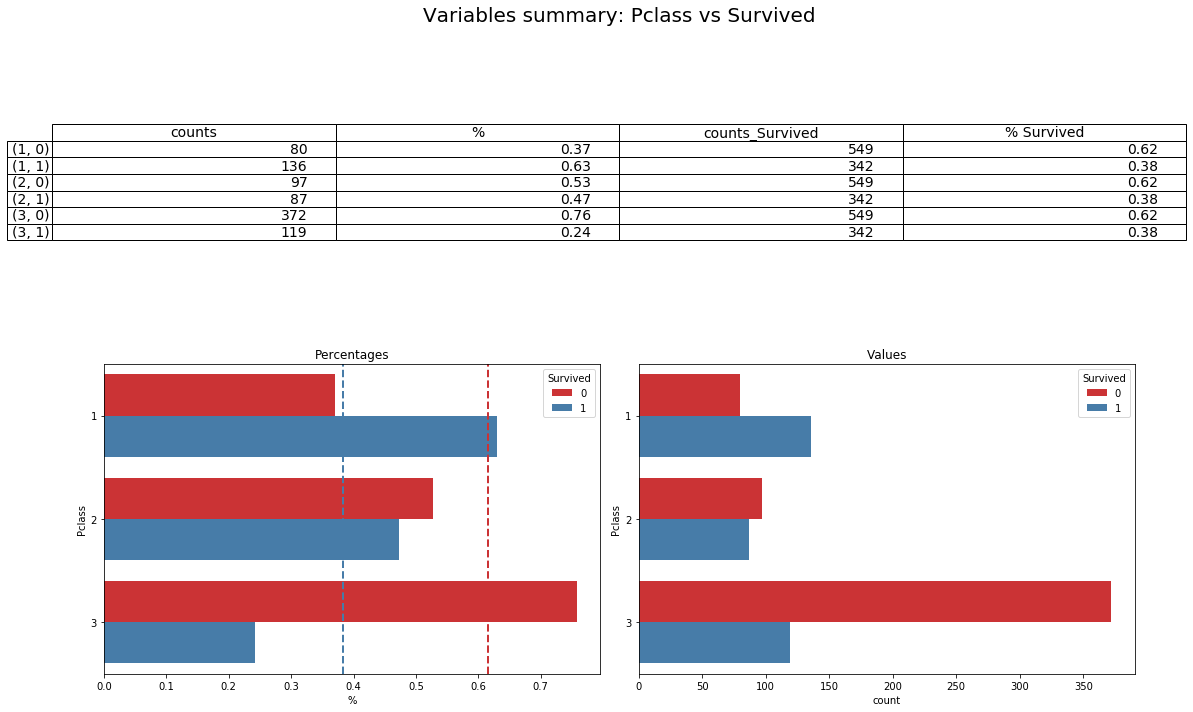

In [325]:
categorical_summarized(train_df, variables = ['Pclass'], target="Survived")

In [113]:
#def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, order=None):
def categorical_summarized(dataframe, variables=None, target=None, palette='Set1', ax=None, order=None):
    '''
    Helper function that gives a quick summary of a given column of categorical data

    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot

    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    
    '''
    Possible cases:
    
    - variables is None --> ERROR
    - variables is string and target is None --> Univariate plot
    - variables is list of one and target is None --> Univariate plot
    - variables is list of two and target is None --> Bi-variate plot
    - variables is list of three and target is None --> Tri-variate plot
    - variable is a list of more than 3 and target is None --> ERROR
    - variables is string and target is a string --> Bi-variate plot
    - variables is list of one and target is a string --> Bi-variate plot
    - variables is list of two and target is a string --> Tri-variate plot
    - variables is list of three and target a string --> ERROR
    - variable is a list of more than 3 and target is a string --> ERROR
    '''
    
    
    if variables is None:
        return;
    elif (isinstance(variables, str)) and (target is None):
        # Univariate plot
        categorical_univariate(dataframe, column = variables, palette=palette, ax=ax, order=order)
    elif (type(variables) is list) and (len(variables) == 1) and (target is None):
        # Univariate plot
        categorical_univariate(dataframe, column = variables[0], palette=palette, ax=ax, order=order)
    elif (type(variables) is list) and (len(variables) == 2) and (target is None):
        # Bi-variate plot
        return;
    elif (type(variables) is list) and (len(variables) == 3) and (target is None):
        # Tri-variate plot
        return;
    elif (type(variables) is list) and (len(variables) > 3):
        # ERROR
        return;
    elif (isinstance(variables, str)) and (isinstance(target, str)):
        #Bi-variate plot
        categorical_bivariate(dataframe, column=variables, target=target, palette=palette, ax=ax, order=order)
    elif (type(variables) is list) and (len(variables) == 1) and (isinstance(target, str)):
        #Bi-variate plot
        categorical_bivariate(dataframe, column=variables[0], target=target, palette=palette, ax=ax, order=order)
    elif (type(variables) is list) and (len(variables) == 2) and (isinstance(target, str)):
        # Tri-variate plot
        return;
    elif (type(variables) is list) and (len(variables) >= 3) and (isinstance(target, str)):
        # ERROR
        return;
    else:
        # ERROR
        return;

        
    
    #if x == None:
    #    column_interested = y
    #else:
    #    column_interested = x
    #series = dataframe[column_interested]
    #cnts = series.value_counts()
    #
    ##print(series.describe())
    ##print('mode: ', series.mode())
    ##if verbose:
    ##    print('='*80)
   ##     print(series.value_counts())
#
    #sns.countplot(x=x, y=y, hue=hue, data=dataframe,
    #              palette=palette, order=order, ax=ax)
    #plt.show()

In [9]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, order=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data

    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed

    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe,
                palette=palette, order=order, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, order=order, ax=ax)

    plt.show()

In [12]:
DATA_PATH = os.path.join(os.getcwd(), 'Data', 'titanic')

In [13]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

In [16]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [14]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Categorical

For categorical variables:

* Count for each category; percentage for each category (+ missing values)
* Bar plot

For categorical variables vs categorical target:

* Count and pct for each category
* Count and pct for each category-target
* Grouped bar plot

For categorical variables vs numerical target:

* Describe of numerical target
* Describe of numerical target for each category
* Boxplots for each category

OPTIONAL

* Overlapping histogram of target for each category
* QQ-plot of target distribution globally and for each category




In [34]:
isinstance("check", str)

True

In [143]:
categorical_summarized(train_df, variables = ['Sex'], target="Survived" )

TypeError: cannot convert the series to <class 'float'>

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object
mode:  0    male
dtype: object
male      577
female    314
Name: Sex, dtype: int64


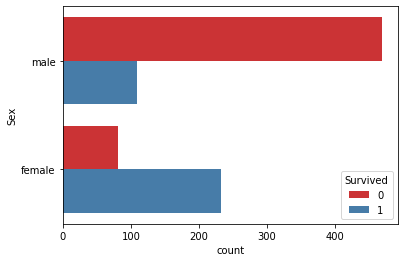

In [19]:
categorical_summarized(train_df, y = 'Sex', hue='Survived')

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object
mode:  0    S
dtype: object
S    644
C    168
Q     77
Name: Embarked, dtype: int64


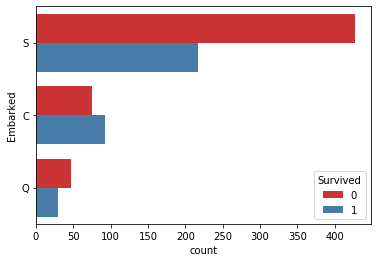

In [20]:
categorical_summarized(train_df, y = 'Embarked', hue = 'Survived')

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
mode:  0    24.0
dtype: float64


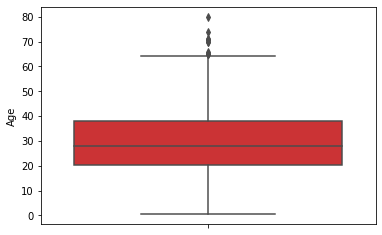

In [21]:
quantitative_summarized(dataframe= train_df, y = 'Age', verbose=False)

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
mode:  0    24.0
dtype: float64
24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64


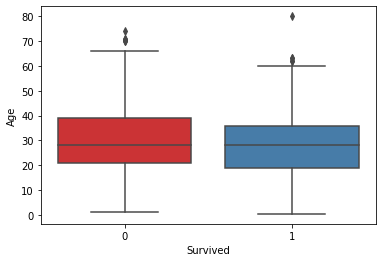

In [22]:
quantitative_summarized(dataframe= train_df, y = 'Age', x = 'Survived', verbose=True)